# Classic Risk Premia Portfolio Backtest

In this notebook we backtest a classic long-only portfolio of ETFs.

Profits are re-invested.

Rebalancing occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the buffer limit only is considered optimal.

In [27]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola


In [28]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD']).dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,120.264046,111.911888,122.080002
2017-10-10,120.548805,112.092422,122.400002
2017-10-11,120.714104,112.309059,122.790001
2017-10-12,120.567146,112.787460,122.889999
2017-10-13,120.658989,113.599838,123.820000
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


In [29]:
weight_df = price_df.copy()
weight_df[:] = [0.6, 0.3, 0.1]
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,0.6,0.3,0.1
2017-10-10,0.6,0.3,0.1
2017-10-11,0.6,0.3,0.1
2017-10-12,0.6,0.3,0.1
2017-10-13,0.6,0.3,0.1
...,...,...,...
2022-10-03,0.6,0.3,0.1
2022-10-04,0.6,0.3,0.1
2022-10-05,0.6,0.3,0.1


In [30]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2017-10-09 VTI      120.264046         0.000000      0.000000        0.000000   
           TLT      111.911888         0.000000      0.000000        0.000000   
           GLD      122.080002         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2017-10-10 VTI      120.548805        49.890223   6014.206716        0.601922   
...                        ...              ...           ...             ...   
2022-10-06 cash       1.000000       672.530129    672.530129        0.050090   
2022-10-07 VTI      182.399994        41.932921   7648.564528        0.581539   
           TLT      100.989998        35.032512   3537.933361        0.268998   
           GLD      157.880005         8.191350   1293.250348        0.098329   
           cash       1.000000       672.530129    672.530129        0.051134   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2017-10-09 VTI       6.000000e-01      0.600000      True           0.600000   
           TLT       3.000000e-01      0.300000      True           0.300000   
           GLD       1.000000e-01      0.100000      True           0.100000   
           cash      1.110223e-16     -1.000000     False           1.000000   
2017-10-10 VTI       6.000000e-01     -0.001922     False           0.601922   
...                           ...           ...       ...                ...   
2022-10-06 cash      1.110223e-16     -0.050090     False           0.050090   
2022-10-07 VTI       6.000000e-01      0.018461     False           0.581539   
           TLT       3.000000e-01      0.031002     False           0.268998   
           GLD       1.000000e-01      0.001671     False           0.098329   
           cash      1.110223e-16     -0.051134     False           0.051134   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2017-10-09 VTI                   0.6       6000.0   49.890223        10.0   
           TLT                   0.3       3000.0   26.806804        10.0   
           GLD                   0.1       1000.0    8.191350        10.0   
           cash                  0.0          0.0    0.000000         0.0   
2017-10-10 VTI                   0.0          0.0    0.000000         0.0   
...                              ...          ...         ...         ...   
2022-10-06 cash                  0.0          0.0    0.000000         0.0   
2022-10-07 VTI                   0.0          0.0    0.000000         0.0   
           TLT                   0.0          0.0    0.000000         0.0   
           GLD                   0.0          0.0    0.000000         0.0   
           cash                  0.0          0.0    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2017-10-09 VTI          49.890223  
           TLT          26.806804  
           GLD           8.191350  
           cash        -30.000000  
2017-10-10 VTI          49.890223  
...                           ...  
2022-10-06 cash        672.530129  
2022-10-07 VTI          41.932921  
           TLT          35.032512  
           GLD           8.191350  
           cash        672.530129  

[5036 rows x 13 columns]

In [31]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df)

16

price  start_portfolio       equity  current_weight  \
datetime   Symbols                                                             
2017-10-09 VTI      120.264046         0.000000     0.000000        0.000000   
           TLT      111.911888         0.000000     0.000000        0.000000   
           GLD      122.080002         0.000000     0.000000        0.000000   
2018-08-07 VTI      137.197144        49.890223  6844.796019        0.640454   
2018-12-20 VTI      117.989220        46.738902  5514.686583        0.556830   
2020-03-09 VTI      132.790436        50.362473  6687.654673        0.542216   
           TLT      164.092438        26.806804  4398.793743        0.356642   
2020-03-23 VTI      107.296585        55.729625  5979.598405        0.559646   
2020-04-08 VTI      131.812073        59.748125  7875.524172        0.645891   
2020-06-04 TLT      151.230606        22.549367  3410.154407        0.258305   
2020-06-05 VTI      155.996857        55.502941  8658.284323        0.648383   
2021-01-05 TLT      151.548309        26.189264  3968.938615        0.259987   
2021-01-06 VTI      190.445480        51.361241  9781.516156        0.642472   
2021-03-12 VTI      202.389801        47.965864  9707.801669        0.640969   
2021-04-27 TLT      134.866852        30.219941  4075.668304        0.258788   
2022-09-12 VTI      205.776382        44.900035  9239.366760        0.642455   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2017-10-09 VTI                0.6      0.600000      True                0.6   
           TLT                0.3      0.300000      True                0.3   
           GLD                0.1      0.100000      True                0.1   
2018-08-07 VTI                0.6     -0.040454      True                0.6   
2018-12-20 VTI                0.6      0.043170      True                0.6   
2020-03-09 VTI                0.6      0.057784      True                0.6   
           TLT                0.3     -0.056642      True                0.3   
2020-03-23 VTI                0.6      0.040354      True                0.6   
2020-04-08 VTI                0.6     -0.045891      True                0.6   
2020-06-04 TLT                0.3      0.041695      True                0.3   
2020-06-05 VTI                0.6     -0.048383      True                0.6   
2021-01-05 TLT                0.3      0.040013      True                0.3   
2021-01-06 VTI                0.6     -0.042472      True                0.6   
2021-03-12 VTI                0.6     -0.040969      True                0.6   
2021-04-27 TLT                0.3      0.041212      True                0.3   
2022-09-12 VTI                0.6     -0.042455      True                0.6   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2017-10-09 VTI              0.600000  6000.000000   49.890223        10.0   
           TLT              0.300000  3000.000000   26.806804        10.0   
           GLD              0.100000  1000.000000    8.191350        10.0   
2018-08-07 VTI             -0.040454  -432.352163   -3.151320        10.0   
2018-12-20 VTI              0.043170   427.542250    3.623570        10.0   
2020-03-09 VTI              0.057784   712.706460    5.367152        10.0   
           TLT             -0.056642  -698.613176   -4.257437        10.0   
2020-03-23 VTI              0.040354   431.171351    4.018500        10.0   
2020-04-08 VTI             -0.045891  -559.566484   -4.245184        10.0   
2020-06-04 TLT              0.041695   550.463794    3.639897        10.0   
2020-06-05 VTI             -0.048383  -646.092218   -4.141700        10.0   
2021-01-05 TLT              0.040013   610.842351    4.030677        10.0   
2021-01-06 VTI             -0.042472  -646.634148   -3.395377    

In [32]:
stats = calc_stats(result)
display(stats)

,equity
start,2017-10-09 00:00:00
end,2022-10-07 00:00:00
rf,0.0
total_return,0.315228
cagr,0.056403
max_drawdown,-0.249298
calmar,0.226247
mtd,0.008168
three_month,-0.065356
six_month,-0.176218


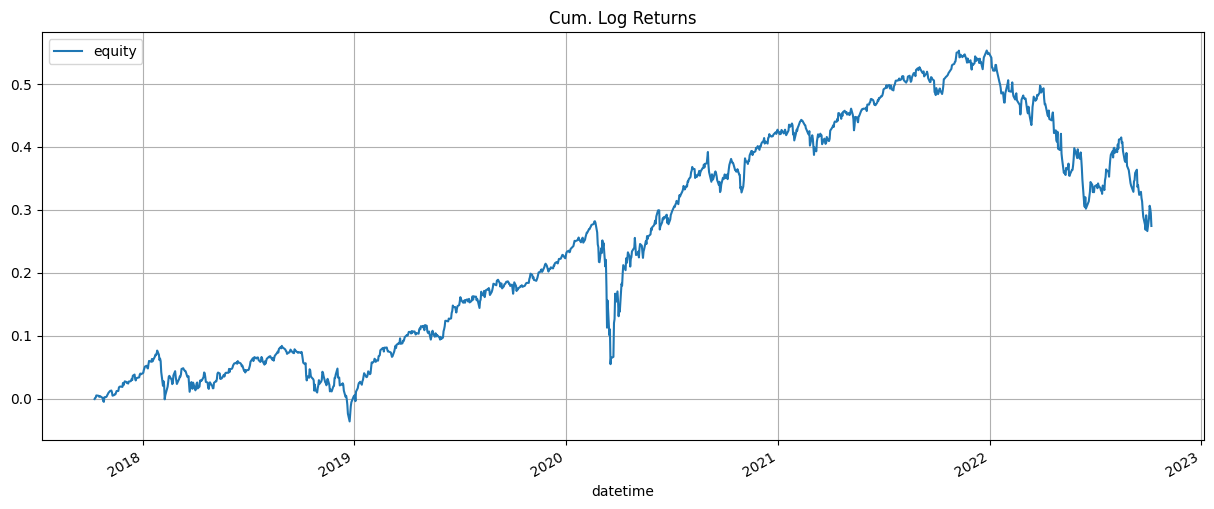

In [33]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

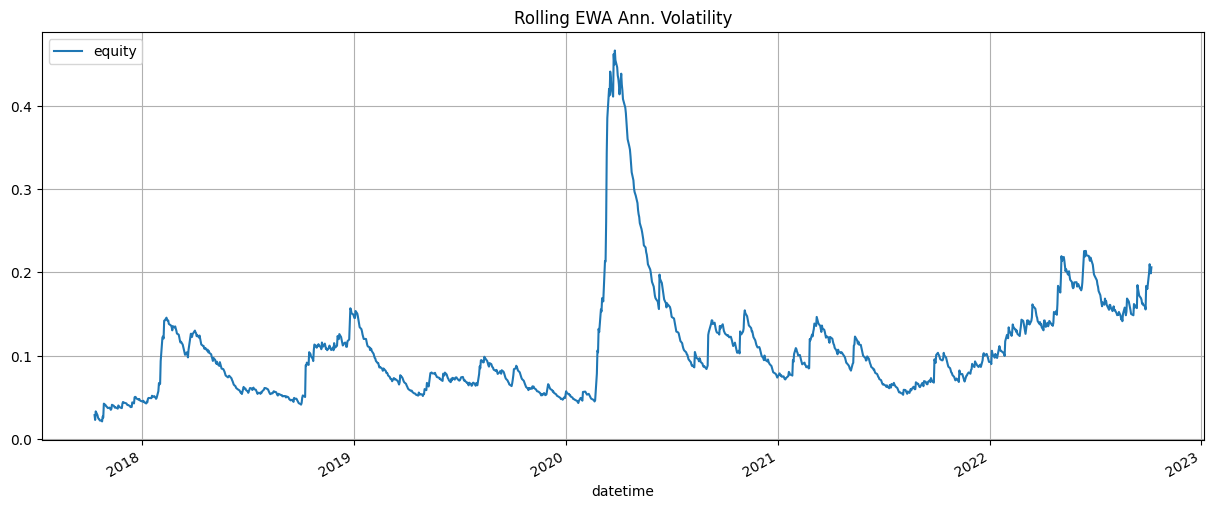

In [34]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()